## Code development to create a national table

https://mapbox.github.io/rasterio/api/rasterio.mask.html?highlight=mask#module-rasterio.mask

http://thematicmapping.org/downloads/world_borders.php

http://www.gadm.org

https://github.com/mapbox/rasterio-cookbook/blob/master/recipies/mask_shp.py


http://gis.stackexchange.com/questions/151339/rasterize-a-shapefile-with-geopandas-or-fiona-python


## Necessary steps (note, this will also be needed in HELIX project...)

* Extract single feature (country shape)
* Reproject feature to match raster
* Convert vector to raster
* Mask original raster by converted raster
* Calculate statistics over mask
* Add to dictionary.
* Repeat for every feature

In [5]:
import fiona
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read shape files using Geopandas and extract a specific country

In [6]:
nations = gpd.read_file('/Users/Ben/Downloads/TM_WORLD_BORDERS-0/TM_WORLD_BORDERS-0.3.shp')

In [7]:
nations.head()

,AREA,FIPS,ISO2,ISO3,LAT,LON,NAME,POP2005,REGION,SUBREGION,UN,geometry
0,44,AC,AG,ATG,17.078,-61.783,Antigua and Barbuda,83039,19,29,28,"(POLYGON ((-61.686668 17.02444100000014, -61.7..."
1,238174,AG,DZ,DZA,28.163,2.632,Algeria,32854159,2,15,12,"POLYGON ((2.96361 36.802216, 2.981389 36.80693..."
2,8260,AJ,AZ,AZE,40.430,47.395,Azerbaijan,8352021,142,145,31,(POLYGON ((45.08332100000001 39.76804400000015...
3,2740,AL,AL,ALB,41.143,20.068,Albania,3153731,150,39,8,"POLYGON ((19.436214 41.021065, 19.450554 41.05..."
4,2820,AM,AM,ARM,40.534,44.563,Armenia,3017661,142,145,51,(POLYGON ((45.57305100000013 40.63248800000008...


In [8]:
nations[nations.ISO3 == "GBR"]

,AREA,FIPS,ISO2,ISO3,LAT,LON,NAME,POP2005,REGION,SUBREGION,UN,geometry
206,24193,UK,GB,GBR,53.0,-1.6,United Kingdom,60244834,150,154,826,"(POLYGON ((-6.290832999999964 49.912216, -6.31..."


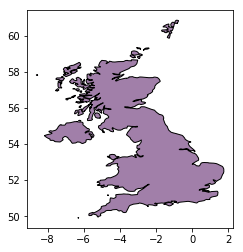

In [9]:
nations[nations.ISO3 == "GBR"].plot()

In [10]:
uk = nations[nations.ISO3 == "GBR"].geometry

### Extract statistics for vector area of a Raster

* Identify coordinate system of raster
* Extract geometry of concern (for script, can read country codes from a YAML file and iterate for each)
* Use (reprojected) vector, with raster with rasterstats zonal_stats

In [67]:
from rasterstats import zonal_stats
import rasterio
import pyproj

In [70]:
pyproj.pj_list['laea']

'Lambert Azimuthal Equal Area'

In [73]:
pyproj.pj_ellps

{'APL4.9': {'a': 6378137.0,
  'description': 'Appl. Physics. 1965',
  'rf': 298.25},
 'CPM': {'a': 6375738.7,
  'description': 'Comm. des Poids et Mesures 1799',
  'rf': 334.29},
 'GRS67': {'a': 6378160.0,
  'description': 'GRS 67(IUGG 1967)',
  'rf': 298.247167427},
 'GRS80': {'a': 6378137.0,
  'description': 'GRS 1980(IUGG, 1980)',
  'rf': 298.257222101},
 'IAU76': {'a': 6378140.0, 'description': 'IAU 1976', 'rf': 298.257},
 'MERIT': {'a': 6378137.0, 'description': 'MERIT 1983', 'rf': 298.257},
 'NWL9D': {'a': 6378145.0,
  'description': ' Naval Weapons Lab., 1965',
  'rf': 298.25},
 'SEasia': {'a': 6378155.0,
  'b': 6356773.3205,
  'description': 'Southeast Asia'},
 'SGS85': {'a': 6378136.0,
  'description': 'Soviet Geodetic System 85',
  'rf': 298.257},
 'WGS60': {'a': 6378165.0, 'description': 'WGS 60', 'rf': 298.3},
 'WGS66': {'a': 6378145.0, 'description': 'WGS 66', 'rf': 298.25},
 'WGS72': {'a': 6378135.0, 'description': 'WGS 72', 'rf': 298.26},
 'WGS84': {'a': 6378137.0, 'desc

In [78]:
uk.to_crs(epsg='3857')

206    (POLYGON ((-700292.3262255189 6431087.05511784...
Name: geometry, dtype: object

In [101]:
inData.crs

CRS({'y_0': 3210000, 'lon_0': 10, 'lat_0': 52, 'units': 'm', 'proj': 'laea', 'towgs84': '0,0,0,0,0,0,0', 'no_defs': True, 'ellps': 'GRS80', 'x_0': 4321000, 'wktext': True})

In [94]:
# try to get the EPSG string back from this data automatically ='EPSG:3857'
inData.crs.data

{'ellps': 'GRS80',
 'lat_0': 52,
 'lon_0': 10,
 'no_defs': True,
 'proj': 'laea',
 'towgs84': '0,0,0,0,0,0,0',
 'units': 'm',
 'x_0': 4321000,
 'y_0': 3210000}

In [63]:
# Grab raster metadata
input_raster = "/Users/Ben/Downloads/eurolst_clim/eurolst_clim.bio01.tif"
with rasterio.open(input_raster, blockxsize=256, blockysize=256) as inData:
    profile = inData.profile
    meta = inData.meta

In [65]:
profile['crs']

CRS({'y_0': 3210000, 'lon_0': 10, 'lat_0': 52, 'units': 'm', 'proj': 'laea', 'towgs84': '0,0,0,0,0,0,0', 'no_defs': True, 'ellps': 'GRS80', 'x_0': 4321000})

LAEA can be identified on this site http://spatialreference.org/ref/?search=laea&srtext=Search as being EPSG:3035

In [64]:
#uk.to_crs(epsg="3035").plot()  # reprojection of vector looks good
uk.to_crs(epsg="laea").plot() 

ValueError: invalid literal for int() with base 10: 'laea'

In [55]:
output = zonal_stats(uk.to_crs(epsg="3035"), input_raster, band=1, all_touched=True, raster_out=True)
output

[{'count': 3903334,
  'max': 126.0,
  'mean': 85.5642222776734,
  'min': 25.0,
  'mini_raster_affine': Affine(250.0, 0.0, 3156750.0,
       0.0, -250.0, 4239500.0),
  'mini_raster_array': masked_array(data =
   [[-- -- -- ..., -- -- --]
   [-- -- -- ..., -- -- --]
   [-- -- -- ..., -- -- --]
   ..., 
   [-- -- -- ..., -- -- --]
   [-- -- -- ..., -- -- --]
   [-- -- -- ..., -- -- --]],
               mask =
   [[ True  True  True ...,  True  True  True]
   [ True  True  True ...,  True  True  True]
   [ True  True  True ...,  True  True  True]
   ..., 
   [ True  True  True ...,  True  True  True]
   [ True  True  True ...,  True  True  True]
   [ True  True  True ...,  True  True  True]],
         fill_value = 999999),
  'mini_raster_nodata': -32768.0}]

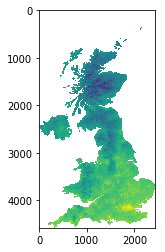

In [57]:
plt.imshow(output[0]['mini_raster_array'])  # Test that we subsetted the raster where we were expecting

### Exploring the Raster in more detail

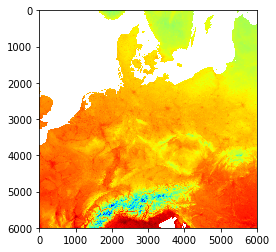

In [46]:
with rasterio.open("/Users/Ben/Downloads/eurolst_clim/eurolst_clim.bio01.tif", blockxsize=256, blockysize=256) as inData:
    window = (6000, 12000), (6000, 12000)
    window2 = (6000, 8000), (6000, 8000)
    profile = inData.profile
    cmap = plt.get_cmap('jet')
    meta = inData.meta
    dslice = inData.read(1, window=window, masked=False)
    show(inData.read(1, window=window, masked=True), cmap=cmap, interpolation='none')

In [58]:
profile['crs']['proj']

'laea'

In [44]:
profile['transform']

Affine(250.0, 0.0, 2168000.0,
       0.0, -250.0, 5447750.0)